In [137]:
from collections import defaultdict
import re
import pandas as pd
import numpy as np
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

In [2]:
genete_annot = pd.read_csv('../data/gffs/danRer11.nonalt.genes_tes.gtf', sep='\t', header=None)
genete_annot = genete_annot.loc[genete_annot[2] == 'exon']
genete_annot['len'] = abs(genete_annot[3] - genete_annot[4])
genete_annot['gene'] = genete_annot[8].apply(lambda x: x.split()[3].strip(';').strip('"'))
genelengths = genete_annot[['gene', 'len']] \
    .groupby('gene') \
    .sum() \
    .reset_index()
genelengths = dict(zip(genelengths['gene'], genelengths['len']))

/Users/jonwells/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
sample_df = pd.read_csv('../data/expression/White2017/elife-30860-supp1-v1.tsv', sep='\t')
sample_df = sample_df.rename({'accession_number': 'sampleAccession'}, axis=1)
print(sample_df)

           sample                public_name sampleAccession    condition  \
0     zmp_ph133_B        ZMP_phenotype_133_B      ERS1079239  ZFS:0000001   
1     zmp_ph133_D        ZMP_phenotype_133_D      ERS1079240  ZFS:0000001   
2     zmp_ph133_E        ZMP_phenotype_133_E      ERS1079241  ZFS:0000001   
3     zmp_ph133_F        ZMP_phenotype_133_F      ERS1079243  ZFS:0000001   
4     zmp_ph133_G        ZMP_phenotype_133_G      ERS1079244  ZFS:0000001   
..            ...                        ...             ...          ...   
508  zmp_ph122_E5  ZMP_phenotype_122_5dpf_E5       ERS626209  ZFS:0000037   
509  zmp_ph122_E6  ZMP_phenotype_122_5dpf_E6       ERS626210  ZFS:0000037   
510  zmp_ph122_E7  ZMP_phenotype_122_5dpf_E7       ERS626211  ZFS:0000037   
511  zmp_ph122_E8  ZMP_phenotype_122_5dpf_E8       ERS626212  ZFS:0000037   
512  zmp_ph122_E9  ZMP_phenotype_122_5dpf_E9       ERS626213  ZFS:0000037   

             stage stageName             sampleName sequencing  
0    Zygot

In [4]:
def load_counts(tecountsfile):
    accession = re.search('(ERS\d+)\.', tecountsfile).group(1)
    tecount_df = pd.read_csv(tecountsfile, skiprows=1, header=None, names=['gene', 'reads'], sep='\t')
    tecount_df['gene'] = tecount_df['gene'].apply(lambda x: x.split(':')[0])
    tecount_df[accession] = tecount_df['reads']
    return tecount_df[['gene', accession]]

accessions = {}
with open('../data/expression/White2017/sample_list.txt') as infile:
    accessions = {line.split()[0]: line.split()[1:] for line in infile}
    
countdata = []
for acc in accessions.keys():
    countdata.append(load_counts(f'../data/expression/TEcount-out/{acc}.cntTable'))
counts_df = pd.concat(countdata, axis=1, join='inner') \
              .drop('gene', axis=1)
counts_df['gene'] = countdata[0]['gene']
print(counts_df.head())

   ERS1079138  ERS1079139  ERS1079140  ERS1079141  ERS1079142  ERS1079143  \
0           9          18          15          19          22          12   
1           6           3           1           1           3          56   
2         384         341         433         482         309         262   
3         702         759         835         713         669         545   
4         417         451         414         410         398          98   

   ERS1079144  ERS1079145  ERS1079146  ERS1079147  ...  ERS1079234  \
0          13          14          20          15  ...         110   
1          41          68          73          36  ...          14   
2         264         390         344         251  ...        1010   
3         442         655         539         396  ...        1334   
4         106         136         107          80  ...         528   

   ERS1079235  ERS1079236  ERS1079238  ERS1079239  ERS1079240  ERS1079241  \
0          99          92          80  

In [5]:
tpm_df = counts_df.melt(id_vars='gene', var_name='sampleAccession', value_name='counts')
tpm_df = tpm_df.merge(sample_df[['sampleAccession', 'stageName', 'sequencing']], 
                                    on='sampleAccession', 
                                    how='left')
tpm_df = tpm_df.loc[tpm_df.sequencing == 'RNASeq']

tpm_df = tpm_df.groupby(['stageName', 'sequencing', 'gene']) \
    .median() \
    .reset_index() \
    .drop('sequencing', 1)

ascale = tpm_df.groupby('stageName')['counts'].sum()/1e06
ascale = dict(zip(ascale.reset_index().stageName, ascale.reset_index().counts))
tpm_df['len'] = tpm_df['gene'].apply(lambda x: genelengths[x])
tpm_df['rpk'] = tpm_df['counts']/(tpm_df['len']/1000)
tpm_df['ascale'] = tpm_df['stageName'].apply(ascale.get)
tpm_df['tpm'] = tpm_df['rpk']/tpm_df['ascale']
tpm_df = tpm_df.drop(['rpk', 'ascale', 'len', 'counts'], axis=1)


stageorder = ['1-cell', 
             '2-cell', 
             '128-cell', 
             '1k-cell', 
             'Dome', 
             '50pc-epiboly', 
             'Shield', 
             '75pc-epiboly', 
             '1-4-somites', 
             '14-19-somites', 
             '20-25-somites',
             'Prim-5',
             'Prim-15',
             'Prim-25',
             'Long-pec',
             'Protruding-mouth',
             'Day-4',
             'Day-5']
tpm_df['stageName'] = pd.Categorical(tpm_df['stageName'], stageorder)
tpm_df = tpm_df.sort_values(['gene', 'stageName'])
print(tpm_df.loc[tpm_df.gene == 'BHIKHARI_LTR'].head())

       stageName          gene       tpm
35422     1-cell  BHIKHARI_LTR  0.000633
176474    2-cell  BHIKHARI_LTR  0.003102
70685   128-cell  BHIKHARI_LTR  0.003625
141211   1k-cell  BHIKHARI_LTR  0.008969
388052      Dome  BHIKHARI_LTR  1.599772


In [234]:
finz = []
with open('../data/gffs/gffcmp.Danio_rerio_finz.denovo.gff.tmap') as infile:
    header = infile.readline()
    for line in infile:
        line = line.split()
        finz.append(line[3])
            
expressed = set(tpm_df.loc[(tpm_df.tpm > 5) & (tpm_df.gene.isin(finz)), 'gene'].to_list())
print(len(finz))
print(len(expressed))

817
299


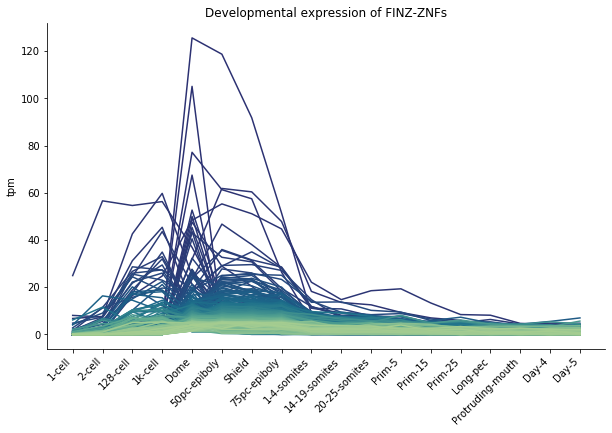

In [235]:
fig, ax = plt.subplots(figsize=(10, 6))

hue_order = list(tpm_df.loc[tpm_df.gene.isin(expressed)].groupby('gene').max().reset_index().sort_values('tpm')['gene'])

sns.lineplot(data=tpm_df.loc[tpm_df.gene.isin(expressed)],
             x='stageName', 
             y='tpm', 
             sort=False,
             hue='gene',
             hue_order=hue_order[::-1],
             palette='crest_r',
             lw=1.5,
             ax=ax)

ax.set_title('Developmental expression of FINZ-ZNFs')
ax.get_legend().remove()
ax.set_xlabel('')
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.show()

In [236]:
finz_matrix = tpm_df.loc[tpm_df['gene'].isin(expressed)].drop('cluster', axis=1)
finz_matrix['zscore'] = finz_matrix.groupby('gene').transform(lambda x: (x - x.mean())/x.std())
finz_matrix = finz_matrix[['gene', 'stageName', 'zscore']].set_index('gene')
finz_matrix = finz_matrix.pivot(columns='stageName', values='zscore')

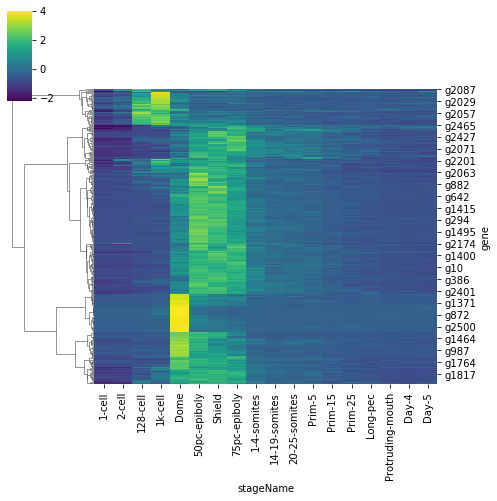

In [241]:
fig = sns.clustermap(data=finz_matrix, 
                     cmap="viridis", 
                     col_cluster=False,
                     method='ward',
                     figsize=(7, 7))
plt.show()

nclusts = 3
for pair in zip(cluster.hierarchy.cut_tree(fig.dendrogram_row.linkage, nclusts), finz_matrix.index):
    clusters[pair[1]] = pair[0][0]
tpm_df['cluster'] = np.nan
tpm_df['cluster'] = tpm_df['gene'].apply(clusters.get)

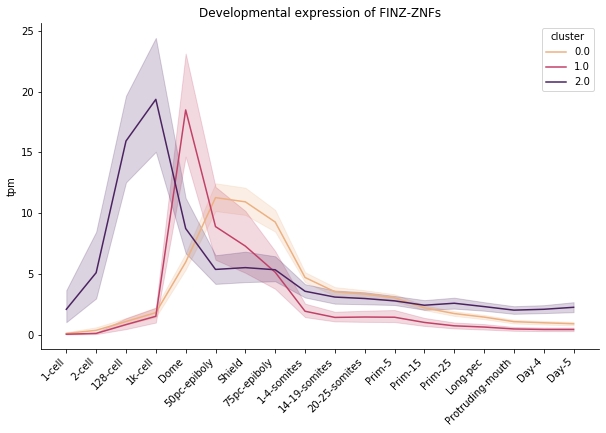

In [242]:
fig, ax = plt.subplots(figsize=(10, 6))
# g = sns.FacetGrid(tpm_df.loc[tpm_df.gene.isin(finz)])
sns.lineplot(data=tpm_df.loc[tpm_df.gene.isin(expressed)],
             x='stageName', 
             y='tpm', 
             sort=False,
             hue='cluster',
             palette='flare',
             lw=1.5,
             ax=ax)

ax.set_title('Developmental expression of FINZ-ZNFs')
# ax.get_legend().remove()
ax.set_xlabel('')
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.show()

In [243]:
clades = {}
for i in [1, 2, 3, 4, 5, 6, 7, 8]:
    with open(f'../data/selection-analysis/pairwise_needleman_clade{i}.taxa') as infile:
        clades[i] = [re.search('(g\d+)', line).group(1) for line in infile]
for k, v in clades.items():
    print(v)

['g113', 'g1190', 'g1371', 'g1484', 'g1512', 'g1670', 'g203', 'g2385', 'g695', 'g808']
['g1357', 'g1501', 'g1685', 'g2373', 'g2388', 'g2499', 'g537', 'g589', 'g834', 'g926']
['g1130', 'g1137', 'g1415', 'g1848', 'g2415', 'g2503', 'g596', 'g688', 'g749', 'g775']
['g1037', 'g109', 'g1150', 'g1588', 'g1734', 'g1944', 'g2237', 'g762', 'g840', 'g865']
['g1226', 'g1265', 'g1676', 'g1764', 'g2283', 'g2484', 'g292', 'g525', 'g587', 'g950', 'g959']
['g1100', 'g1125', 'g1700', 'g1955', 'g1964', 'g2340', 'g2434', 'g2470', 'g673', 'g758', 'g817']
['g1007', 'g1423', 'g1450', 'g1615', 'g1840', 'g1867', 'g2285', 'g2379', 'g680', 'g818', 'g928', 'g943']
['g1015', 'g1044', 'g1396', 'g1789', 'g1832', 'g2353', 'g393', 'g410', 'g637', 'g667', 'g888', 'g902']


               stageName   gene       tpm  cluster clade
69393             1-cell  g1007  0.000000      0.0     7
210445            2-cell  g1007  0.000000      0.0     7
104656          128-cell  g1007  0.000000      0.0     7
175182           1k-cell  g1007  0.000000      0.0     7
422023              Dome  g1007  2.487298      0.0     7
...                  ...    ...       ...      ...   ...
528609           Prim-25   g959  0.000000      1.0     5
458083          Long-pec   g959  0.000000      1.0     5
599135  Protruding-mouth   g959  0.000000      1.0     5
352294             Day-4   g959  0.000000      1.0     5
387557             Day-5   g959  0.000000      1.0     5

[1548 rows x 5 columns]


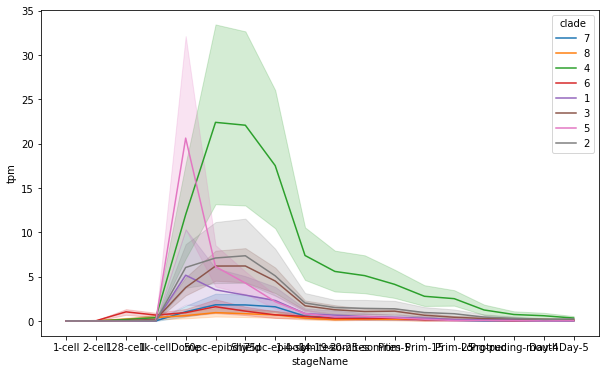

In [249]:
rev_clades = {gene: str(key) for key, value in clades.items() for gene in value}
clades_df = tpm_df.loc[tpm_df.gene.isin(rev_clades.keys())].copy()
clades_df['clade'] = clades_df['gene'].apply(rev_clades.get)
print(clades_df)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=clades_df,
             x='stageName', 
             y='tpm', 
             sort=False,
             hue='clade',
#              palette='flare',
             lw=1.5,
             ax=ax)
plt.show()

In [246]:
coexpression = []
for gene1 in sorted(rev_clades.keys(), key=lambda x: int(rev_clades[x])):
    row = []
    for gene2 in sorted(rev_clades.keys(), key=lambda x: int(rev_clades[x])):
        cor = stats.pearsonr(clades_df.loc[clades_df.gene == gene1, 'tpm'],
                                 clades_df.loc[clades_df.gene == gene2, 'tpm'])
        row.append(cor[0])
    coexpression.append(row)
coexpression = np.array(coexpression)

/Users/jonwells/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


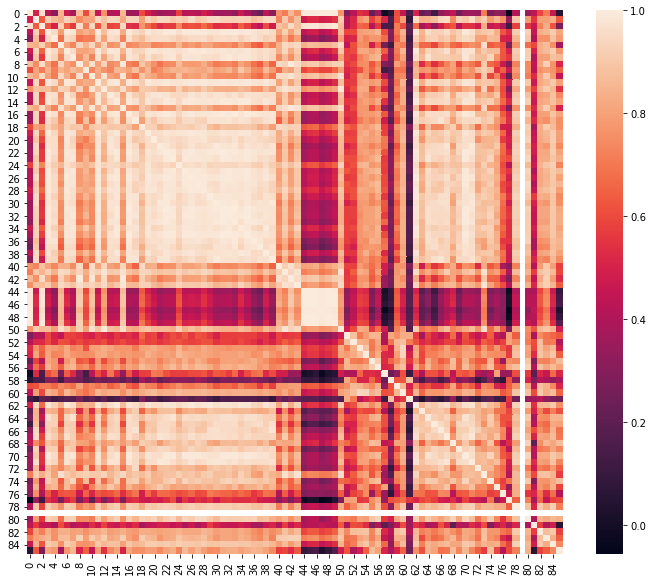

In [247]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(coexpression)